In [51]:
import psycopg2
import random
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:

# Параметры подключения к базе данных (обновите с вашими учетными данными)
DB_PARAMS = {
    "dbname": "postgres",
    "user": "anrewqz",
    "password": "12345678",
    "host": "localhost",
    "port": "5432"
}

In [77]:
# Подключение к базе данных
conn = psycopg2.connect(**DB_PARAMS)
cursor = conn.cursor()
cursor.execute("SET search_path TO fb;")
conn.commit()

Добавим в БД много матчей между командами, а затем посмотрим на турнирную таблицу, которую показывает представление league_table

In [34]:
# Функция для добавления новых матчей
def insert_matches(num_matches):  
    cursor.execute("SELECT COALESCE(MAX(team_id), 0) FROM teams")
    max_team_id = int(cursor.fetchone()[0])
    
    successful_inserts = 0
    # Генерируем и добавляем матчи
    for i in range(num_matches):

        # генерируем команды
        home_team_id = random.randint(1, max_team_id)
        guest_team_id = random.randint(1, max_team_id)
        while guest_team_id == home_team_id:
            guest_team_id = random.randint(1, max_team_id)
        
        # Генерируем случайные счета
        home_team_scored = max(0, round(np.random.normal(1.5, 1)))
        guest_team_scored = max(0, round(np.random.normal(1.5, 1)))
        
        try:
          cursor.execute(
              """
              INSERT INTO matches (home_team_id, guest_team_id, home_team_scored, guest_team_scored)
              VALUES (%s, %s, %s, %s)
              """,
              (home_team_id, guest_team_id, home_team_scored, guest_team_scored)
          )
          successful_inserts += 1
          
        except psycopg2.Error as e:
            conn.rollback() 
            print(f"Ошибка при добавлении матча с (home_team_id, guest_team_id)={(home_team_id, guest_team_id)}: {e}")
            
    conn.commit()
    print(f"Успешно добавлено {successful_inserts} новых матчей из {num_matches} попыток.")
    

In [35]:
insert_matches(1000) # Добавим много матчей

Успешно добавлено 1000 новых матчей из 1000 попыток.


In [46]:
# Функция для сохранения данных из представления league_table в CSV-файл
def get_league_table(filename):
    cursor.execute("SELECT rank, team, matches, points, goals_scored, goals_conceded, goal_diff FROM league_table")
    results = cursor.fetchall()
    
    headers = ["Место", "Команда", "Сыграно матчей", "Очки", "Голов забито", "Голов пропущено", "Разница голов"]
    # Записываем данные в CSV-файл
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(headers)  # Записываем заголовки
        writer.writerows(results)  # Записываем данные
    
    print(f"Данные из league_table сохранены в файл {filename}.")


In [47]:
# Сохраним турнирную таблицу в .csv файл
get_league_table("league_table.csv")

Данные из league_table сохранены в файл league_table.csv.


In [78]:
# Закрываем подключение
conn.close()

In [48]:
data = pd.read_csv("league_table.csv")
data

,Место,Команда,Сыграно матчей,Очки,Голов забито,Голов пропущено,Разница голов
0,1,Зенит,143,226,235,211,24
1,2,Рубин,146,215,217,194,23
2,3,Спартак,163,212,223,240,-17
3,4,Динамо,137,197,203,184,19
4,5,Манчестер Сити,141,192,198,207,-9
5,6,ПСЖ,133,184,201,209,-8
6,6,ФК Машина,135,184,209,217,-8
7,8,Барселона,127,179,188,183,5
8,9,Ливерпуль,132,177,199,197,2
9,10,Краснодар,118,169,177,163,14


**Первая гипотеза**
- Команды из России забивают в среднем больше голов чем остальные


Русских команд: 9, остальных: 6


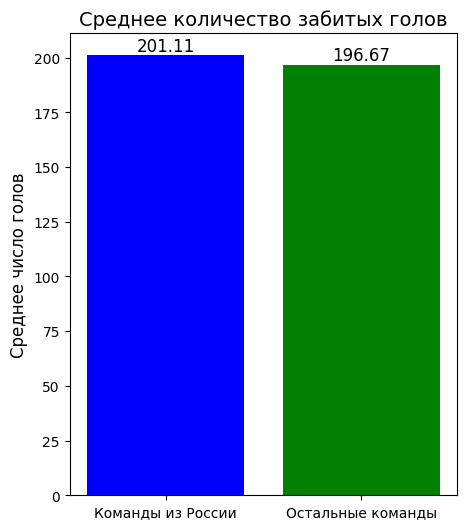

In [69]:
# Определяем команды из России
russian_teams_names = ["Зенит", "Спартак", "Динамо", "ЦСКА", "Краснодар", "Ростов", "Рубин", "МФК Тюмень", "ФК Машина"]
    
russian_teams = data[data["Команда"].isin(russian_teams_names)]
other_teams = data[~data["Команда"].isin(russian_teams_names)]
print(f"Русских команд: {russian_teams.shape[0]}, остальных: {other_teams.shape[0]}")

# Извлекаем забитые голы
russian_goals = russian_teams["Голов забито"].astype(int)
other_goals = other_teams["Голов пропущено"].astype(int)
    
# Вычисляем средние значения
mean_russian_goals = np.mean(russian_goals)
mean_other_goals = np.mean(other_goals)

# Построение графика
categories = ["Команды из России", "Остальные команды"]
values = [mean_russian_goals, mean_other_goals]
    
plt.figure(figsize=(5, 6))
plt.bar(categories, values, color=["blue", "green"])

plt.title("Среднее количество забитых голов", fontsize=14)
plt.ylabel("Среднее число голов", fontsize=12)

for i, v in enumerate(values):
    plt.text(i, v + 2, f"{v:.2f}", ha="center", fontsize=12)

plt.show()


**Вывод:** наша гипотеза подтвердилась, команды из России правда играют в более атакующий футбол.

**Вторая гипотеза**
- Чем больше разница забитых и пропущенных голов, тем выше место команды


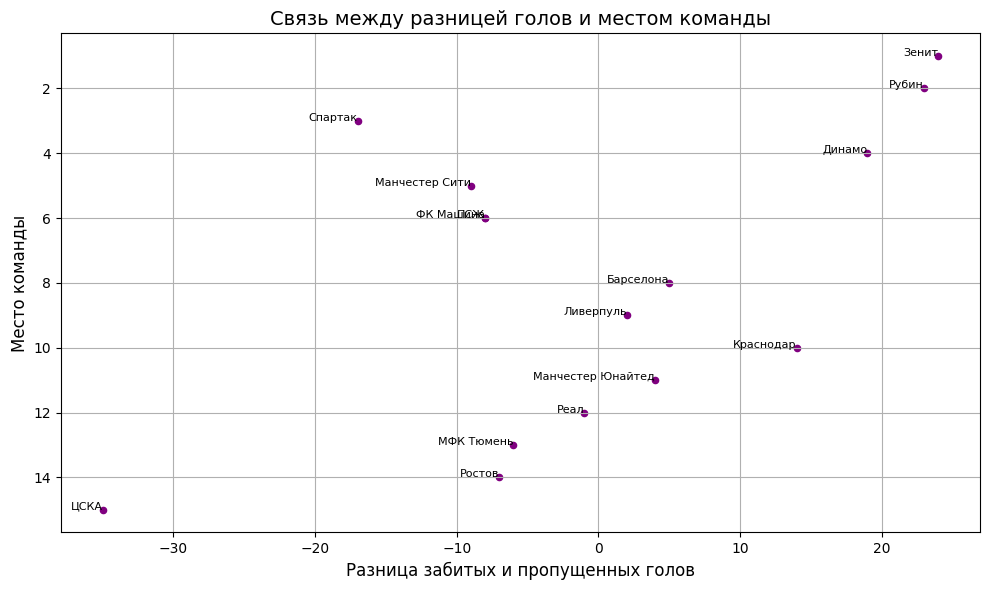

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(data["Разница голов"], data["Место"], color='purple', s=20)

# Подписываем каждую точку названием команды
for i in range(len(data)):
    plt.text(data["Разница голов"].iloc[i], data["Место"].iloc[i], 
             data["Команда"].iloc[i], fontsize=8, ha='right')

plt.xlabel("Разница забитых и пропущенных голов", fontsize=12)
plt.ylabel("Место команды", fontsize=12)
plt.title("Связь между разницей голов и местом команды", fontsize=14)

# Инвертируем ось Y: 1 место — вверху, а не внизу
plt.gca().invert_yaxis()

plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод:** по графику видно, что гипотеза, выдвиннутая нами выполняется совсем не всегда. Например, команды Спартак, Манчестер Сити, ФК Машина и ПСЖ, имеют худшие среди всех команд (после ЦСКА) разницы забитых и пропущенных мячей, но при этом на ходятся в верхней половине турнирной таблицы.

**Третья гипотеза**
- Большинство команд забило больше 200 голов


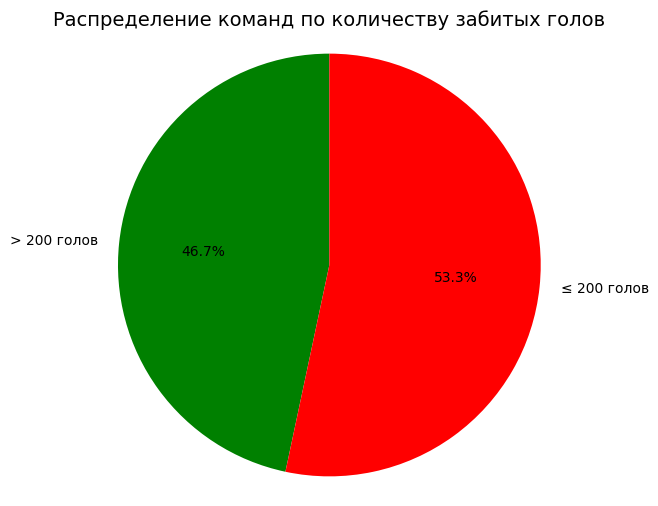

In [76]:
more_than_200 = (data["Голов забито"] > 200).sum()
less_or_equal_200 = (data["Голов пропущено"] <= 200).sum()

# Данные для диаграммы
labels = ['> 200 голов', '≤ 200 голов']
sizes = [more_than_200, less_or_equal_200]
colors = ['green', 'red']

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Распределение команд по количеству забитых голов", fontsize=14)
plt.axis('equal')  # Сделать круг круглым

plt.show()

**Вывод:** круговая диаграмма показала, что больше половины команд забила не более 200 голов. Наша гипотеза неверна.